In [1]:
import numpy as np
import pandas as pd
from os import listdir, makedirs, walk
from os.path import isdir, isfile, join, exists, expanduser
from tqdm import tqdm_notebook
import datetime
from itertools import compress

from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, deserialize
from keras.utils import to_categorical
from keras.applications import mobilenet
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import *

from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

/home/paperspace/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## View underlying data

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 16

train_folder      = 'data/train/'
valid_folder      = 'data/validation/'
test_folder       = 'data/test'
weights_folder    = 'models/'

bottleneck_features_train_npy = 'bottleneck_features_train.npy'
bottleneck_features_valid_npy = 'bottleneck_features_valid.npy'
bottleneck_labels_train_npy = 'bottleneck_labels_train.npy'
bottleneck_labels_valid_npy = 'bottleneck_labels_valid.npy'

top_model_epochs = 50
complete_model_epochs = 50

augmented_images_multiply_factor = 3

# Create weights folder to save model weights
if not exists(weights_folder):
    makedirs(weights_folder)
    
ext = '.jpg'
classes = [fldr for fldr in listdir(train_folder) if isdir(join(train_folder, fldr))]
num_classes = len(classes)
train_samples = sum([len(files) for r, d, files in walk(train_folder)])
valid_samples = sum([len(files) for r, d, files in walk(valid_folder)])
test_samples = sum([len(files) for r, d, files in walk(test_folder)])

print ("Classes: {}, Training samples: {}, Validation samples: {}, Test samples: {}".format(num_classes, train_samples, valid_samples, test_samples))

Classes: 21, Training samples: 947, Validation samples: 341, Test samples: 32


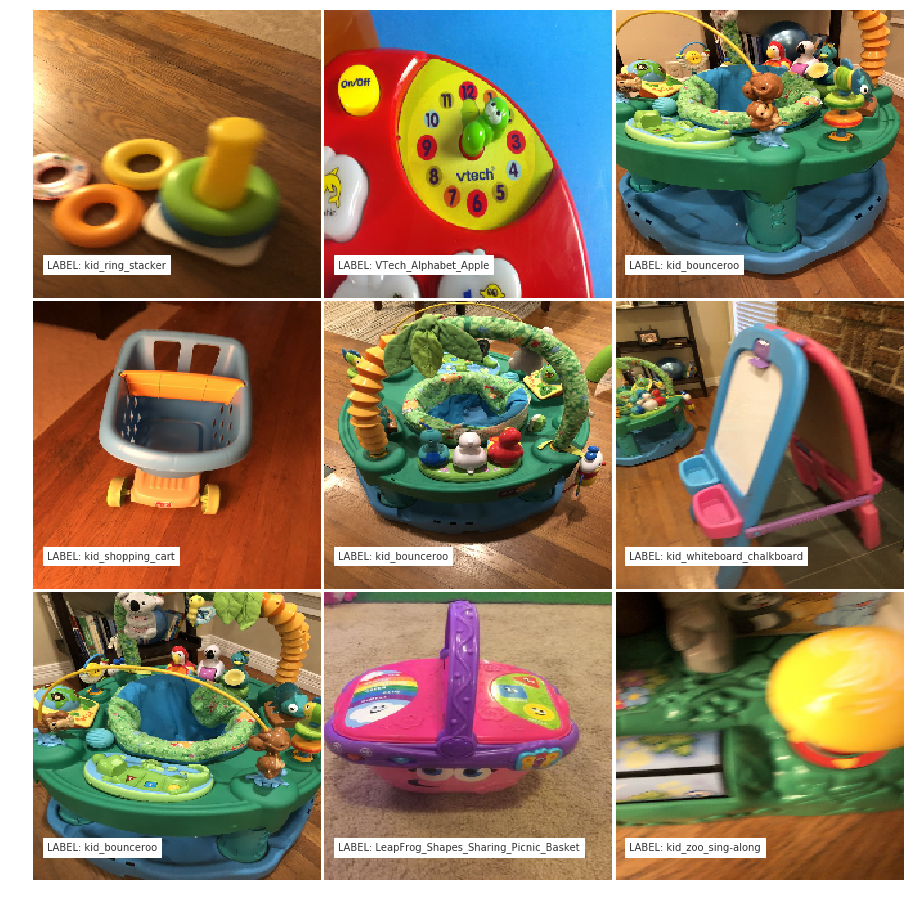

In [3]:
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

for i, cls in enumerate(np.random.choice(classes, 9)):
    ax = grid[i]
    img_file = np.random.choice(listdir(join(train_folder, cls)))
    img = image.load_img(join(train_folder, cls, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 200, 'LABEL: %s' % cls, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

## Adapting [Keras example](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) for MobileNet model with multiclass classification

1. Create base model and save bottleneck features
2. Train top-model with bottleneck features
3. Setup data to flow from directory with augmentation
4. Fine tune base model

## 1. Create base model and save bottleneck features

In [4]:
# Creating wrapper for input preprocessing from https://nbviewer.jupyter.org/gist/embanner/6149bba89c174af3bfd69537b72bca74 
def preprocess_input_mobilenet(x):
    """Wrapper around keras.applications.mobilenet.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.mobilenet.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [5]:
base_model = mobilenet.MobileNet(weights='imagenet', alpha=0.5, include_top=False, input_shape = (INPUT_SIZE,INPUT_SIZE,3), input_tensor=Input(shape=(INPUT_SIZE,INPUT_SIZE,3)))

5578752/5577668 [==============================] - 0s 0us/step


In [6]:
if not exists(bottleneck_features_train_npy):
    # Set up data generator for bottleneck features - only need preprocessing (no augmentation)
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)

    # Generate bottleneck features for training data, and accompanying labels
    generator = datagen.flow_from_directory(
        train_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_train = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_train_npy, bottleneck_features_train)

    bottleneck_labels_train = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_train_npy, bottleneck_labels_train)
    
else:
    bottleneck_features_train = np.load(bottleneck_features_train_npy)
    bottleneck_labels_train = np.load(bottleneck_labels_train_npy)

Found 947 images belonging to 21 classes.
60/60 [==============================] - 30s 501ms/step


In [7]:
if not exists(bottleneck_features_valid_npy):
    # Generate bottleneck features for validation data, and accompanying labels
    generator = datagen.flow_from_directory(
        valid_folder,
        target_size=(INPUT_SIZE, INPUT_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False)

    bottleneck_features_valid = base_model.predict_generator(generator, verbose = 1)
    np.save(bottleneck_features_valid_npy, bottleneck_features_valid)

    bottleneck_labels_valid = to_categorical(generator.classes, num_classes=num_classes)
    np.save(bottleneck_labels_valid_npy, bottleneck_labels_valid)

else:
    bottleneck_features_valid = np.load(bottleneck_features_valid_npy)
    bottleneck_labels_valid = np.load(bottleneck_labels_valid_npy)    

Found 341 images belonging to 21 classes.
22/22 [==============================] - 11s 488ms/step


## 2. Create and train top-model with bottleneck features

In [8]:
top_model = Sequential()

# Based on https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
# top_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))

# https://www.kaggle.com/abnera/transfer-learning-keras-xception-cnn
# top_model.add(GlobalAveragePooling2D(input_shape=bottleneck_features_train.shape[1:]))

# Based on https://www.depends-on-the-definition.com/transfer-learning-for-dog-breed-identification/
top_model.add(BatchNormalization(input_shape=bottleneck_features_train.shape[1:]))
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.5))
top_model.add(Dense(1024, activation='relu'))
top_model.add(Dropout(0.5))
 
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer=SGD(nesterov=True),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# From https://github.com/bckenstler/CLR for Cyclical Learning Rate
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [16]:
# save weights of best training epoch: monitor either val_loss or val_acc
STAMP = "{}_top_model".format(datetime.datetime.now().strftime("%Y-%m-%d"))
top_model_weights_path = "models/{}.h5".format(STAMP)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 2000
clr = CyclicLR(base_lr=0.008,
               max_lr=0.03,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

callbacks_list = [
    ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    clr
]

top_model.fit(bottleneck_features_train, bottleneck_labels_train,
              batch_size=BATCH_SIZE,
              epochs=top_model_epochs,
              callbacks=callbacks_list,
              validation_data=(bottleneck_features_valid, bottleneck_labels_valid))

Train on 947 samples, validate on 341 samples
Epoch 1/50
947/947 [==============================] - 1s 1ms/step - loss: 0.1857 - acc: 0.9567 - val_loss: 0.3903 - val_acc: 0.9062

Epoch 00001: val_acc improved from -inf to 0.90616, saving model to models/2018-05-11_top_model.h5
Epoch 2/50
947/947 [==============================] - 1s 1ms/step - loss: 0.1894 - acc: 0.9556 - val_loss: 0.3841 - val_acc: 0.9032

Epoch 00002: val_acc did not improve from 0.90616
Epoch 3/50
947/947 [==============================] - 1s 1ms/step - loss: 0.1727 - acc: 0.9609 - val_loss: 0.3851 - val_acc: 0.9062

Epoch 00003: val_acc did not improve from 0.90616
Epoch 4/50
947/947 [==============================] - 1s 1ms/step - loss: 0.2067 - acc: 0.9440 - val_loss: 0.3780 - val_acc: 0.9062

Epoch 00004: val_acc did not improve from 0.90616
Epoch 5/50
947/947 [==============================] - 1s 1ms/step - loss: 0.1802 - acc: 0.9525 - val_loss: 0.3807 - val_acc: 0.9062

Epoch 00005: val_acc did not improve fro

## 3. Setup data to flow from directory with augmentation

In [18]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=train_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenet)
valid_generator = valid_datagen.flow_from_directory(directory=valid_folder,
                                                    target_size=(INPUT_SIZE,INPUT_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 947 images belonging to 21 classes.
Found 341 images belonging to 21 classes.


## 4. Create and fine complete model

In [19]:
# base_model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(INPUT_SIZE,INPUT_SIZE,3)))

# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(num_classes, activation='softmax'))

top_model.load_weights(top_model_weights_path)

# Stack top_model on top
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

for i, layer in enumerate(model.layers):
    print ('Layer #: {}, Name: {}'.format(i, layer.name))

for layer in model.layers[:93]:
    layer.trainable = False
for layer in model.layers[93:]:
    layer.trainable = True
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(optimizer = SGD(lr=1e-4, momentum=0.9),
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Layer #: 0, Name: input_1
Layer #: 1, Name: conv1_pad
Layer #: 2, Name: conv1
Layer #: 3, Name: conv1_bn
Layer #: 4, Name: conv1_relu
Layer #: 5, Name: conv_pad_1
Layer #: 6, Name: conv_dw_1
Layer #: 7, Name: conv_dw_1_bn
Layer #: 8, Name: conv_dw_1_relu
Layer #: 9, Name: conv_pw_1
Layer #: 10, Name: conv_pw_1_bn
Layer #: 11, Name: conv_pw_1_relu
Layer #: 12, Name: conv_pad_2
Layer #: 13, Name: conv_dw_2
Layer #: 14, Name: conv_dw_2_bn
Layer #: 15, Name: conv_dw_2_relu
Layer #: 16, Name: conv_pw_2
Layer #: 17, Name: conv_pw_2_bn
Layer #: 18, Name: conv_pw_2_relu
Layer #: 19, Name: conv_pad_3
Layer #: 20, Name: conv_dw_3
Layer #: 21, Name: conv_dw_3_bn
Layer #: 22, Name: conv_dw_3_relu
Layer #: 23, Name: conv_pw_3
Layer #: 24, Name: conv_pw_3_bn
Layer #: 25, Name: conv_pw_3_relu
Layer #: 26, Name: conv_pad_4
Layer #: 27, Name: conv_dw_4
Layer #: 28, Name: conv_dw_4_bn
Layer #: 29, Name: conv_dw_4_relu
Layer #: 30, Name: conv_pw_4
Layer #: 31, Name: conv_pw_4_bn
Layer #: 32, Name: conv_p

In [24]:
# save weights of best training epoch: monitor either val_loss or val_acc
STAMP = "{}_complete_model".format(datetime.datetime.now().strftime("%Y-%m-%d"))
complete_model_weights_path = "models/{}.h5".format(STAMP)

# Authors suggest setting step_size = (2-8) x (training iterations in epoch)
step_size = 200
clr = CyclicLR(base_lr=8*1e-5,
               max_lr=4*1e-4,
               step_size=step_size,
               mode='exp_range',
               gamma=0.99994)

callbacks_list = [
    ModelCheckpoint(complete_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    clr
]

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_samples // BATCH_SIZE,
                           epochs=complete_model_epochs,
                           callbacks=callbacks_list,
                           validation_data=valid_generator,
                           validation_steps=valid_samples // BATCH_SIZE)

Epoch 1/50
59/59 [==============================] - 51s 857ms/step - loss: 1.0599 - acc: 0.6797 - val_loss: 0.5373 - val_acc: 0.8869

Epoch 00001: val_acc improved from -inf to 0.88690, saving model to models/2018-05-11_complete_model.h5
Epoch 2/50
59/59 [==============================] - 52s 882ms/step - loss: 1.1891 - acc: 0.6527 - val_loss: 0.5289 - val_acc: 0.8869

Epoch 00002: val_acc did not improve from 0.88690
Epoch 3/50
59/59 [==============================] - 50s 852ms/step - loss: 1.0023 - acc: 0.6773 - val_loss: 0.5462 - val_acc: 0.8810

Epoch 00003: val_acc did not improve from 0.88690
Epoch 4/50
59/59 [==============================] - 52s 874ms/step - loss: 0.9971 - acc: 0.7017 - val_loss: 0.5010 - val_acc: 0.8929

Epoch 00004: val_acc improved from 0.88690 to 0.89286, saving model to models/2018-05-11_complete_model.h5
Epoch 5/50
59/59 [==============================] - 52s 889ms/step - loss: 0.9078 - acc: 0.7158 - val_loss: 0.5060 - val_acc: 0.8839

Epoch 00005: val_ac

KeyboardInterrupt: 

## If testing with unlabeled samples ... 

In [18]:
test_imgs = [f for f in listdir(test_folder) if isfile(join(test_folder, f))]
x_test = np.zeros((len(test_imgs), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

for i, img_file in tqdm_notebook(enumerate(test_imgs)):
    img = image.load_img(join(test_folder, img_file), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('Test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

generator = valid_generator
ypred = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Test Images shape: (32, 224, 224, 3) size: 4,816,896
32/32 [==============================] - 3s 89ms/step


In [19]:
img_list = test_imgs
df = pd.DataFrame.from_dict(generator.class_indices, orient='index')
class_list = df.sort_values(by=0).index.tolist()

In [20]:
pred1_classes = np.argsort(ypred, axis=1)[:,-1] # or np.argmax(ypred, axis=1)
pred2_classes = np.argsort(ypred, axis=1)[:,-2]
pred3_classes = np.argsort(ypred, axis=1)[:,-3]

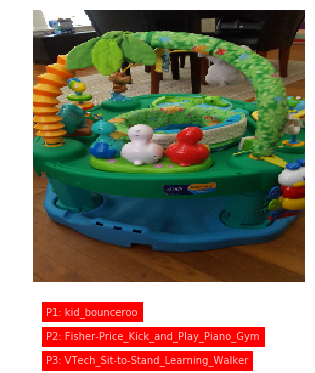

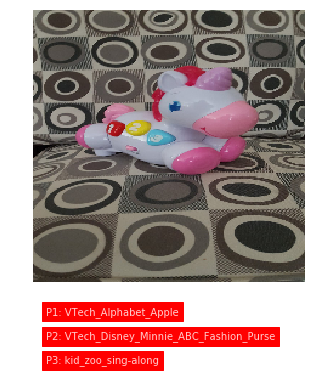

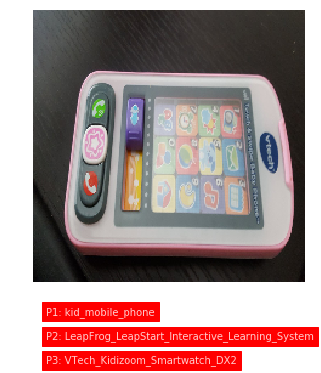

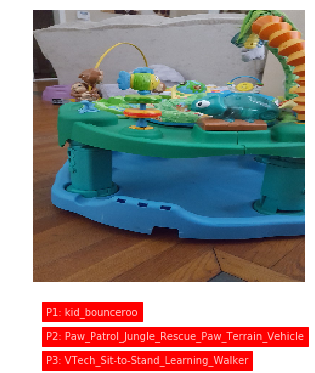

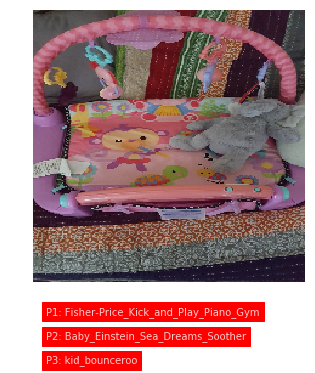

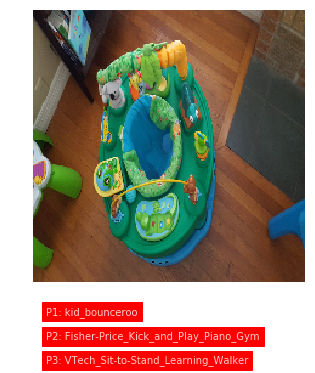

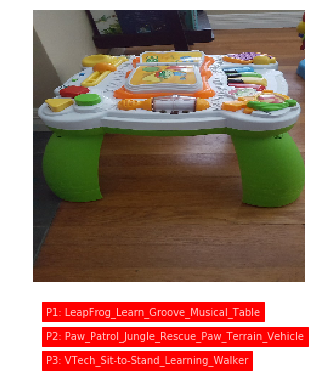

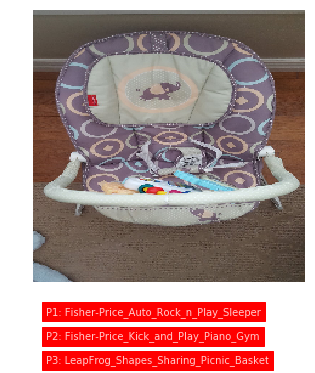

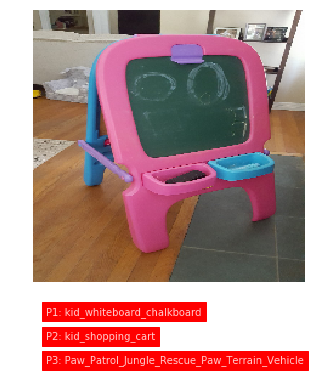

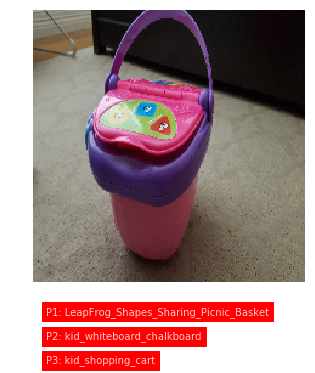

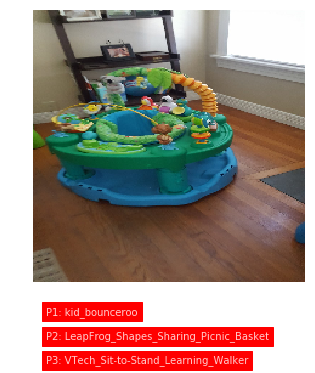

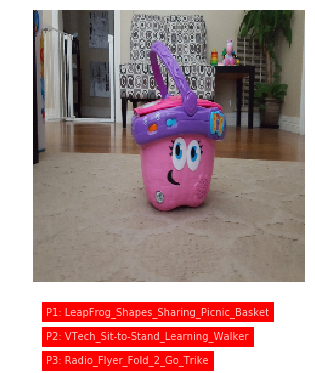

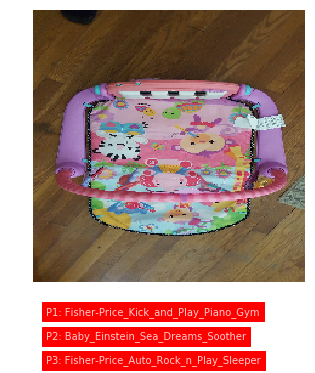

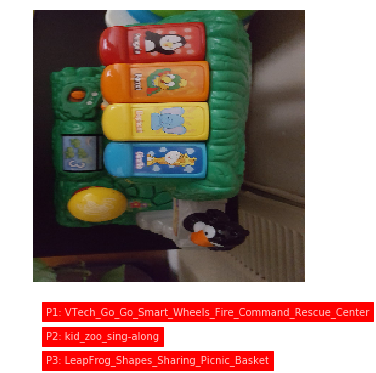

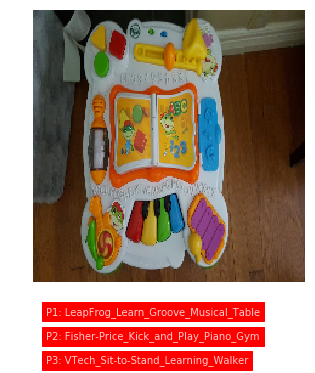

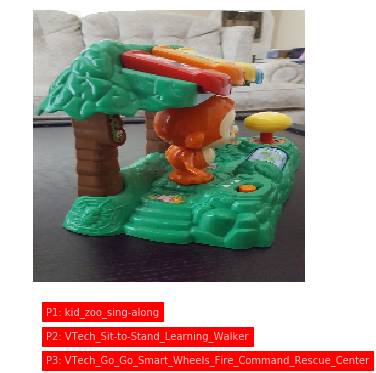

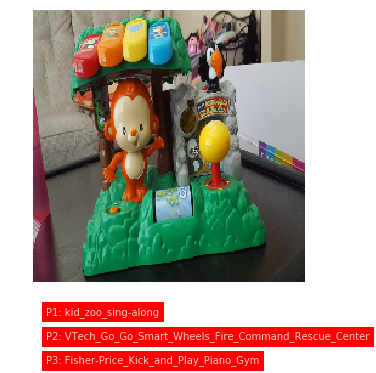

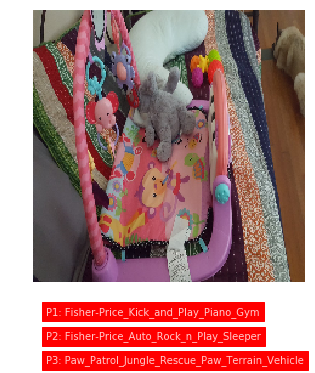

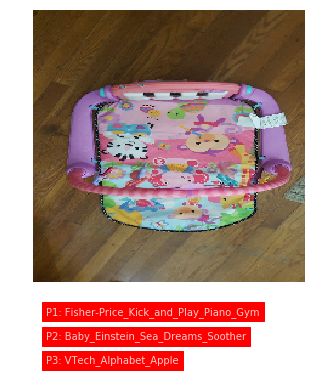

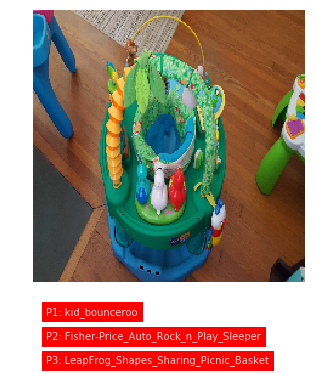

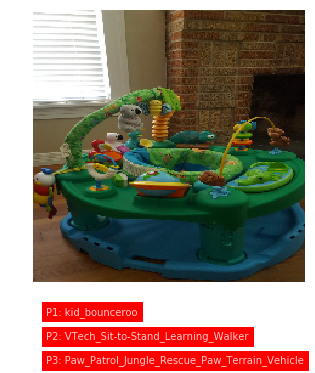

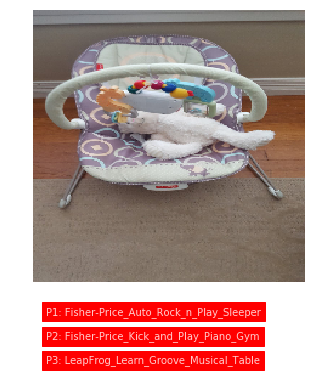

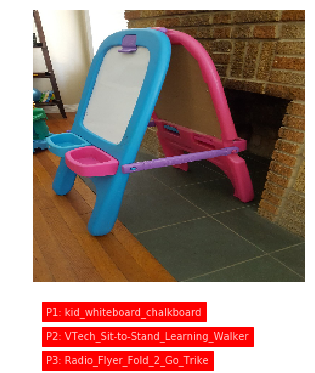

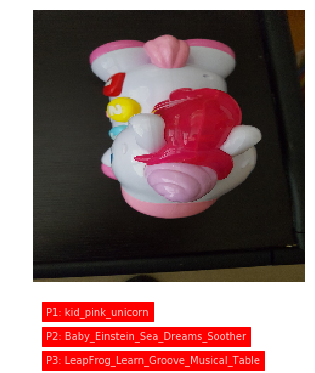

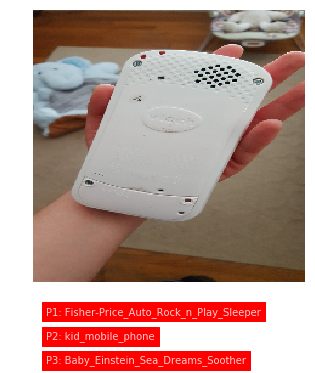

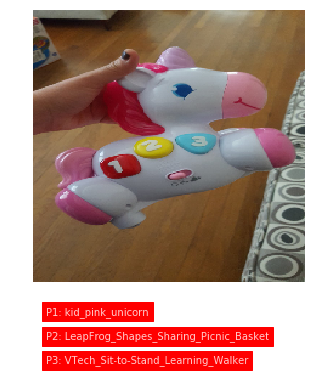

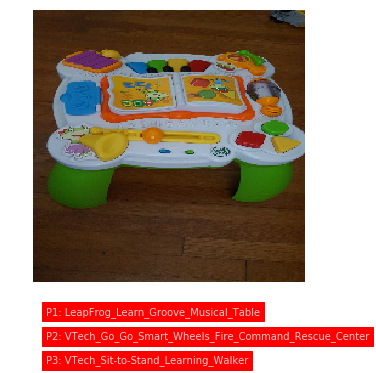

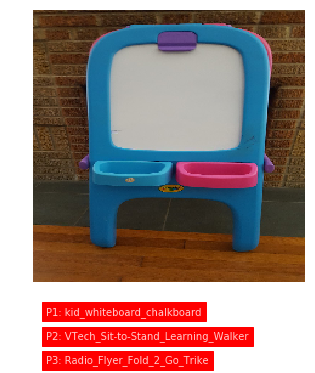

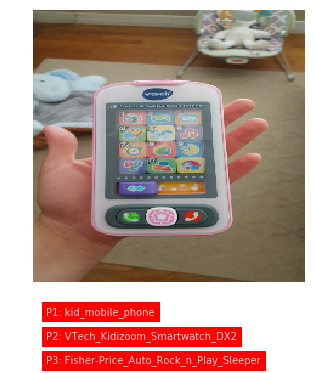

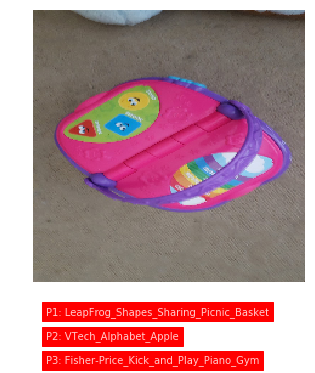

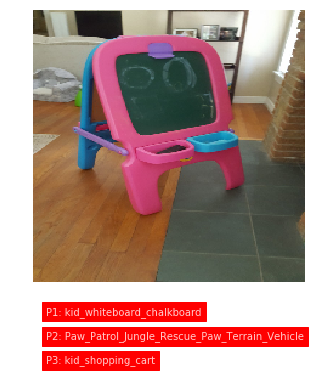

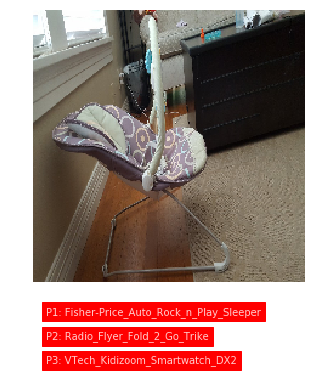

In [21]:
for img_path, pred1, pred2, pred3 in zip(img_list,
                                         [class_list[int(b)] for b in pred1_classes],
                                         [class_list[int(b)] for b in pred2_classes],
                                         [class_list[int(b)] for b in pred3_classes]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(join(test_folder, img_path), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'P1: %s' % pred1, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'P2: %s' % pred2, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 290, 'P3: %s' % pred3, color='w', backgroundcolor='r', alpha=0.8)
    ax.axis('off')
    plt.show()       

## If validating with (labeled samples) ... 

In [25]:
generator = valid_generator
ypred = model.predict_generator(generator, verbose=1)

22/22 [==============================] - 14s 630ms/step


In [26]:
img_list = generator.filenames
df = pd.DataFrame.from_dict(generator.class_indices, orient='index')
class_list = df.sort_values(by=0).index.tolist()

In [27]:
true_classes = generator.classes
pred1_classes = np.argsort(ypred, axis=1)[:,-1] # or np.argmax(ypred, axis=1)
pred2_classes = np.argsort(ypred, axis=1)[:,-2]
pred3_classes = np.argsort(ypred, axis=1)[:,-3]
top1_error_idx = (true_classes != pred1_classes)
top3_error_idx = (true_classes != pred1_classes) & (true_classes != pred2_classes) & (true_classes != pred3_classes)

print ("Of {} images tested, top1 accuracy: {:.2f}% ({} wrong) and top3 accuracy: {:.2f}% ({} wrong)".format(
        len(img_list),
        (1-np.sum(top1_error_idx)/len(img_list))*100, np.sum(top1_error_idx),
        (1-np.sum(top3_error_idx)/len(img_list))*100, np.sum(top3_error_idx)))

Of 341 images tested, top1 accuracy: 88.27% (40 wrong) and top3 accuracy: 95.89% (14 wrong)


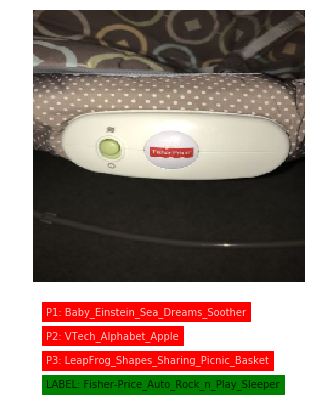

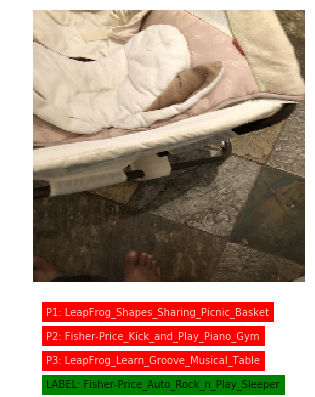

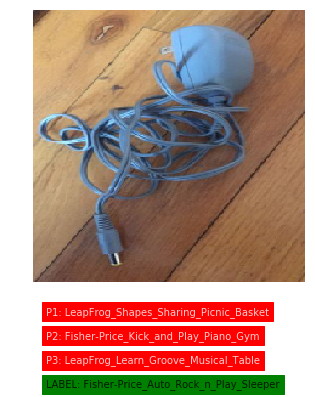

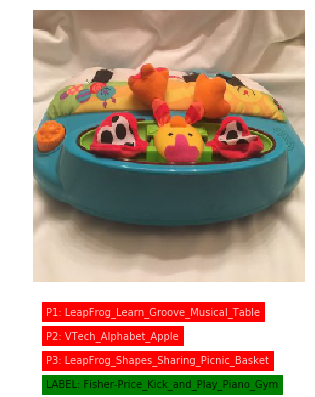

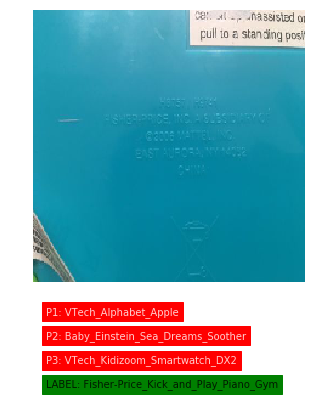

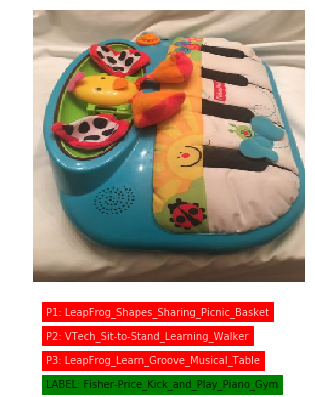

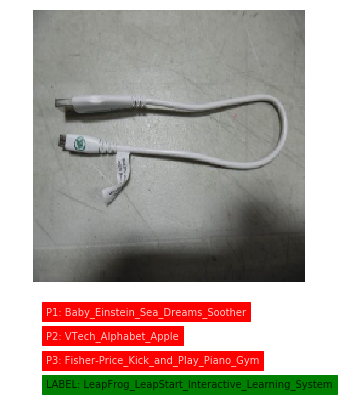

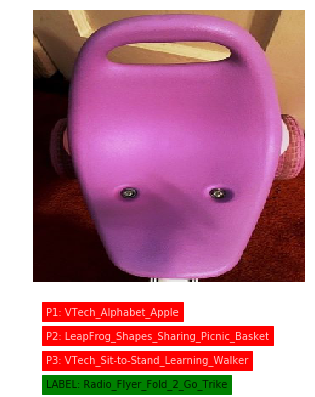

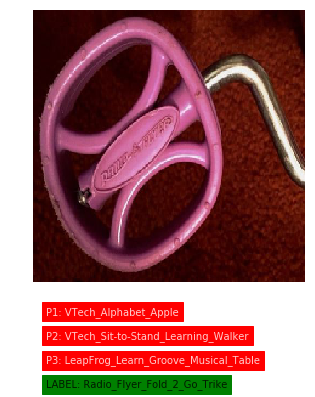

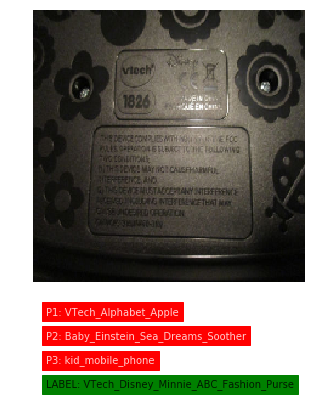

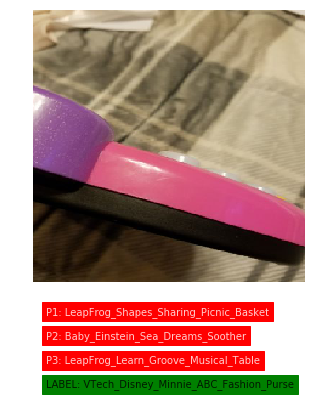

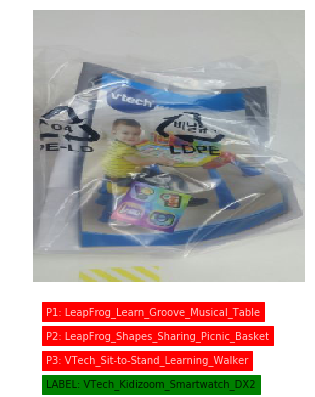

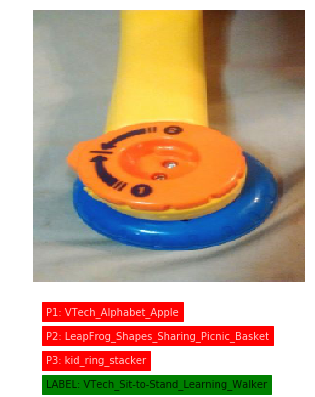

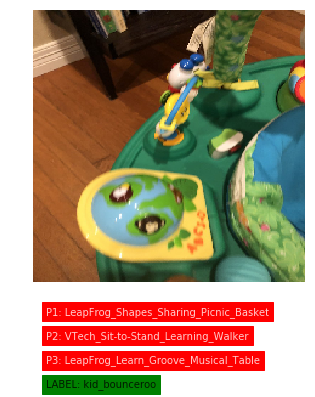

In [28]:
error_idx = top3_error_idx

for img_path, cat, pred1, pred2, pred3 in zip(list(compress(img_list, error_idx)),
                                              [class_list[int(b)] for b in true_classes[error_idx]],
                                              [class_list[int(b)] for b in pred1_classes[error_idx]],
                                              [class_list[int(b)] for b in pred2_classes[error_idx]],
                                              [class_list[int(b)] for b in pred3_classes[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img(join(valid_folder, img_path), target_size=(INPUT_SIZE,INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'P1: %s' % pred1, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'P2: %s' % pred2, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 290, 'P3: %s' % pred3, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 310, 'LABEL: %s' % cat, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()       